In [5]:
pip install pandas numpy matplotlib scipy scikit-learn


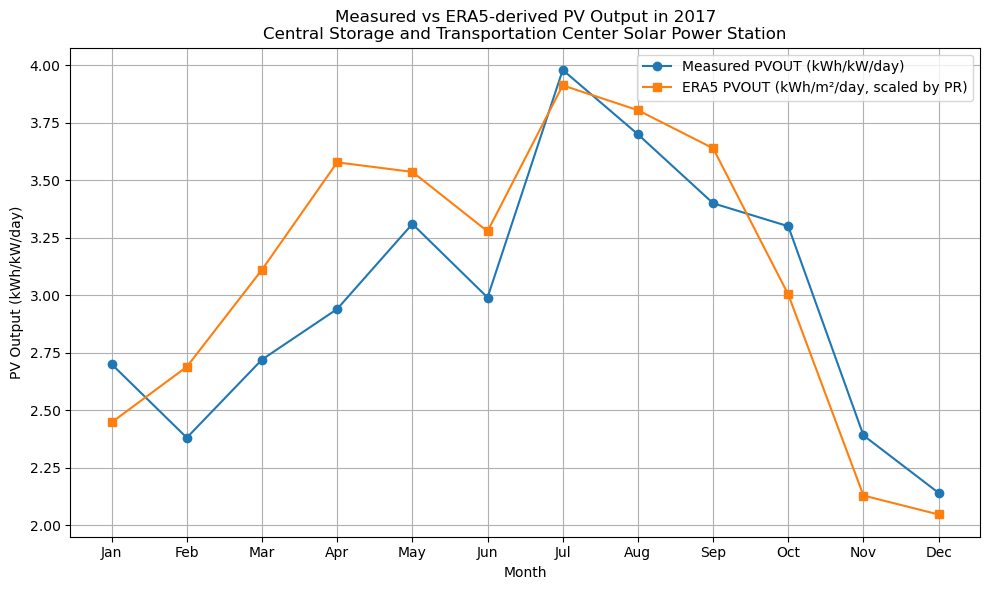

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# -------------------------------
# 1. Load power plant measured data
# -------------------------------

plant_df = pd.read_csv(r"C:\Users\User\Downloads\solar_power_station_monthly_summary_position_updated.csv")
plant_df.columns = plant_df.columns.str.strip()

# Convert 'date' to datetime and extract year/month
plant_df['date'] = pd.to_datetime(plant_df['date'])
plant_df['year'] = plant_df['date'].dt.year
plant_df['month'] = plant_df['date'].dt.month

# User input: target power plant and year
target_name = "Central Storage and Transportation Center Solar Power Station"
target_year = 2017

# Filter for the target plant and year
df_target = plant_df[(plant_df['name'] == target_name) & (plant_df['year'] == target_year)]
df_target = df_target.sort_values('month')

# Get lat/lon for this plant
target_lat = df_target['lat'].iloc[0]
target_lon = df_target['lon'].iloc[0]

# Extract measured monthly average daily output
measured_pvout = df_target['monthly_avg_daily_output']

# -------------------------------
# 2. Load ERA5 RSDS data (real irradiance)
# -------------------------------

era5_df = pd.read_csv(r"C:\Users\User\Downloads\era5_rsds_201625_processed.csv")
era5_df.columns = era5_df.columns.str.strip()

# Convert 'time' to datetime and extract year/month
era5_df['time'] = pd.to_datetime(era5_df['time'])
era5_df['year'] = era5_df['time'].dt.year
era5_df['month'] = era5_df['time'].dt.month

# Filter for target year
era5_year = era5_df[era5_df["year"] == target_year]

# -------------------------------
# 3. Interpolate RSDS to target position and calculate PVOUT
# -------------------------------

interp_monthly_pvout = []

def rsds_to_pvout_from_daily_joules(ssrd_j_m2):
    """
    Convert ERA5 daily accumulated ssrd (J/m²) to PVOUT (kWh/m²/day).
    """
    efficiency = 0.6985
    kwh_m2_day = ssrd_j_m2 / 3_600_000
    pvout_kwh_m2_day = kwh_m2_day * efficiency
    return pvout_kwh_m2_day

for month in range(1, 13):
    df_month = era5_year[era5_year["month"] == month]
    
    if df_month.empty:
        interp_monthly_pvout.append(np.nan)
        continue
    
    # Prepare points and values for interpolation
    points = df_month[["lat","lon"]].values
    values = df_month['ssrd (J/m²)'].values  # Use original J/m² values
    
    # Interpolate to target position using linear
    interp_value_j_m2 = griddata(points, values, (target_lat, target_lon), method='linear')
    
    # Fallback to nearest if linear fails
    if np.isnan(interp_value_j_m2):
        interp_value_j_m2 = griddata(points, values, (target_lat, target_lon), method='nearest')
    
    # Convert to PVOUT using the corrected function
    interp_pvout = rsds_to_pvout_from_daily_joules(interp_value_j_m2)
    interp_monthly_pvout.append(interp_pvout)

# -------------------------------
# 4. Plot comparison
# -------------------------------

plt.figure(figsize=(10,6))
plt.plot(range(1,13), measured_pvout, marker="o", label="Measured PVOUT (kWh/kW/day)")
plt.plot(range(1,13), interp_monthly_pvout, marker="s", label="ERA5 PVOUT (kWh/m²/day, scaled by PR)")
plt.title(f"Measured vs ERA5-derived PV Output in {target_year}\n{target_name}")
plt.xlabel("Month")
plt.ylabel("PV Output (kWh/kW/day)")
plt.xticks(np.arange(1,13), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
from sklearn.metrics import mean_squared_error

# -------------------------------
# 1. Load data
# -------------------------------

# Power plant data
plant_df = pd.read_csv(r"C:\Users\User\Downloads\solar_power_station_monthly_summary_position_updated.csv")
plant_df.columns = plant_df.columns.str.strip()
plant_df['date'] = pd.to_datetime(plant_df['date'])
plant_df['year'] = plant_df['date'].dt.year
plant_df['month'] = plant_df['date'].dt.month

# ERA5 data
era5_df = pd.read_csv(r"C:\Users\User\Downloads\era5_rsds_201625_processed.csv")
era5_df.columns = era5_df.columns.str.strip()
era5_df['time'] = pd.to_datetime(era5_df['time'])
era5_df['year'] = era5_df['time'].dt.year
era5_df['month'] = era5_df['time'].dt.month

# -------------------------------
# 2. Define conversion function
# -------------------------------

def rsds_to_pvout_from_joules(ssrd_j_m2, efficiency=0.8):
    """
    Convert J/m² to kWh/m²/day and apply efficiency (PR).
    """
    kwh_m2_day = ssrd_j_m2 / 3_600_000
    return kwh_m2_day * efficiency

# -------------------------------
# 3. Calculate total RMSE for each PR
# -------------------------------

pr_values = np.arange(0.695, 0.7005, 0.0005)  # PR from 0.05 to 0.8 in steps of 0.05
total_rmse_results = []

for eff in pr_values:
    total_squared_error = 0
    total_count = 0
    
    # Loop through each plant and year
    for plant in plant_df['name'].unique():
        df_plant = plant_df[plant_df['name'] == plant]
        years = df_plant['year'].unique()
        target_lat = df_plant['lat'].iloc[0]
        target_lon = df_plant['lon'].iloc[0]
        
        for year in years:
            df_year = df_plant[df_plant['year'] == year]
            monthly_measured = df_year.groupby('month')['monthly_avg_daily_output'].mean().reindex(range(1,13)).values
            
            # Filter ERA5 for this year
            era5_year = era5_df[era5_df['year'] == year]
            if era5_year.empty:
                continue
            
            # Interpolate ERA5 data
            interp_monthly_joules = []
            for month in range(1,13):
                df_month = era5_year[era5_year["month"] == month]
                if df_month.empty:
                    interp_monthly_joules.append(np.nan)
                    continue
                points = df_month[["lat","lon"]].values
                values = df_month['ssrd (J/m²)'].values
                interp_value = griddata(points, values, (target_lat, target_lon), method='linear')
                if np.isnan(interp_value):
                    interp_value = griddata(points, values, (target_lat, target_lon), method='nearest')
                interp_monthly_joules.append(interp_value)
            
            interp_monthly_joules = np.array(interp_monthly_joules)
            predicted_pvout = rsds_to_pvout_from_joules(interp_monthly_joules, efficiency=eff)
            
            # Calculate squared error for this plant-year
            mask = ~np.isnan(predicted_pvout) & ~np.isnan(monthly_measured)
            if np.sum(mask) < 6:
                continue
            
            squared_errors = (predicted_pvout[mask] - monthly_measured[mask]) ** 2
            total_squared_error += np.sum(squared_errors)
            total_count += np.sum(mask)
    
    # Calculate total RMSE for this PR
    if total_count > 0:
        total_rmse = np.sqrt(total_squared_error / total_count)
    else:
        total_rmse = np.nan
    
    total_rmse_results.append({
        "PR": eff,
        "Total_RMSE": total_rmse
    })
    print(f"PR={eff:.6f}, Total RMSE={total_rmse:.8f}")

# -------------------------------
# 4. Save results
# -------------------------------

results_df = pd.DataFrame(total_rmse_results)
results_df.to_csv(r"C:\Users\User\Downloads\pvout_total_rmse_by_pr_t5.csv", index=False)

print("✅ Total RMSE calculation completed and results saved.")


PR=0.695000, Total RMSE=0.79313250
PR=0.695500, Total RMSE=0.79308333
PR=0.696000, Total RMSE=0.79304077
PR=0.696500, Total RMSE=0.79300482
PR=0.697000, Total RMSE=0.79297549
PR=0.697500, Total RMSE=0.79295277
PR=0.698000, Total RMSE=0.79293666
PR=0.698500, Total RMSE=0.79292717
PR=0.699000, Total RMSE=0.79292429
PR=0.699500, Total RMSE=0.79292802
PR=0.700000, Total RMSE=0.79293837
PR=0.700500, Total RMSE=0.79295534
✅ Total RMSE calculation completed and results saved.


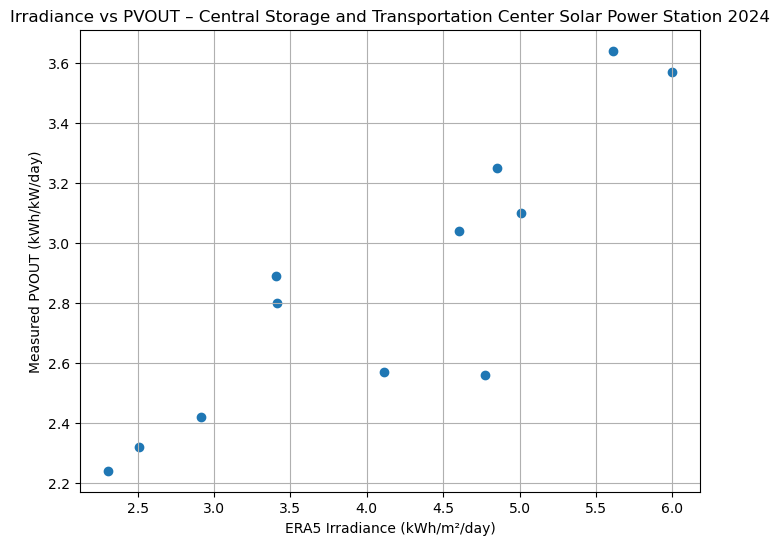

In [9]:
import matplotlib.pyplot as plt

# Example for one plant and year
target_plant = "Central Storage and Transportation Center Solar Power Station"
target_year = 2024

# Filter plant data
df_year = plant_df[(plant_df['name'] == target_plant) & (plant_df['year'] == target_year)]
monthly_measured = df_year.groupby('month')['monthly_avg_daily_output'].mean().reindex(range(1,13)).values

# Filter ERA5 data
era5_year = era5_df[era5_df['year'] == target_year]

interp_monthly_joules = []
for month in range(1,13):
    df_month = era5_year[era5_year["month"] == month]
    if df_month.empty:
        interp_monthly_joules.append(np.nan)
        continue
    points = df_month[["lat","lon"]].values
    values = df_month['ssrd (J/m²)'].values
    interp_value = griddata(points, values, (target_lat, target_lon), method='linear')
    if np.isnan(interp_value):
        interp_value = griddata(points, values, (target_lat, target_lon), method='nearest')
    interp_monthly_joules.append(interp_value)

interp_monthly_joules = np.array(interp_monthly_joules)
irradiance_kwh_m2_day = interp_monthly_joules / 3_600_000  # convert J/m² to kWh/m²/day

# Plot
plt.figure(figsize=(8,6))
plt.scatter(irradiance_kwh_m2_day, monthly_measured)
plt.xlabel("ERA5 Irradiance (kWh/m²/day)")
plt.ylabel("Measured PVOUT (kWh/kW/day)")
plt.title(f"Irradiance vs PVOUT – {target_plant} {target_year}")
plt.grid()
plt.show()
